In [43]:
import os
import subprocess
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import roc_auc_score, precision_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [25]:
# same function from HW3 to download files
group_num = 9
def download_files(group_num, folders = None, redownload = False):
    node_names = {}
    root_folder = f"Group{group_num}"
    root_folder_exist = os.path.exists(root_folder)
    if (not root_folder_exist) or redownload:
        os.system(f"rm -rf {root_folder}")
        os.mkdir(root_folder)
        if folders is None:
            folders = ['Facebook-Ego', 'Twitter-Ego']
        for folder in folders:
            os.mkdir(os.path.join(root_folder, folder))
            res = subprocess.run(["curl", "-s", f"https://api.github.com/repos/1250326/exercise_complex_network/contents/Datasets/Group{group_num}/{folder}"], stdout=subprocess.PIPE)
            for file_info in json.loads(res.stdout):
                os.system(f"wget -O {os.path.join(root_folder, folder, (fname:=file_info['name']))} {file_info['download_url']} -q")
                print(f"Downloaded file: {fname}")
                # if '.' in fname:
                    # node_names[folder.split('-')[0]] = fname.split('.')[0]
            print(f"Downloaded folder: {folder}")
    
        
    for folder in os.listdir(root_folder):
        for file in os.listdir(os.path.join(root_folder, folder)):
            if '.' in file:
                node_names[folder.split('-')[0]] = file.split('.')[0]
    return node_names

node_names = download_files(group_num, redownload=False)
node_names

{'Facebook': '3437_2', 'Twitter': '6408382'}

In [26]:
graph = nx.read_edgelist(f"Group{group_num}/Facebook-Ego/{node_names['Facebook']}.edges")


# Randomly delete 10% of edges


In [27]:
edges = list(graph.edges)
random.shuffle(edges)
num_test_edges = int(0.1 * len(edges))
test_edges = edges[num_test_edges]
train_graph = graph.copy()
train_graph.remove_edges_from(test_edges)

# Extract features for each edge

In [28]:
def extract_features(graph, edge):
    u, v = edge
    common_neighbors = len(list(nx.common_neighbors(graph, u, v)))
    preferential_attachment = graph.degree[u] * graph.degree[v]
    return [common_neighbors, preferential_attachment]

extract_features(graph, edges[10])

[7, 165]

In [29]:
# Positive samples: existing edges
X_pos = [extract_features(train_graph, edge) for edge in train_graph.edges]
y_pos = [1] * len(X_pos)

# Negative samples: non-edges
non_edges = list(nx.non_edges(train_graph))
random.shuffle(non_edges)
X_neg = [extract_features(train_graph, edge) for edge in non_edges[:len(X_pos)]]
y_neg = [0] * len(X_neg)

X = np.array(X_pos + X_neg)
y = np.array(y_pos + y_neg)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Train a logistic regression model


In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

## Evaluate the model

In [31]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"AUROC: {auroc:.2f}")


Accuracy: 0.88
Precision: 0.94
AUROC: 0.95



# Train a neural network using PyTorch


In [ ]:
nn_model = nn.Sequential(
    nn.Linear(X_train.shape[1], 5),
    nn.ReLU(),
    nn.Linear(5, 3),
    nn.ReLU(),
    nn.Linear(3, 1),
    nn.Sigmoid()
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.01)



## Train the neural network


In [39]:
nn_model.train()
for epoch in range(500):
    optimizer.zero_grad()
    output = nn_model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

nn_model.eval()
with torch.no_grad():
    y_pred_nn = nn_model(X_test_tensor).numpy()
    y_pred_nn_bin = (y_pred_nn > 0.5).astype(int)
    accuracy_nn = accuracy_score(y_test, y_pred_nn_bin)
    precision_nn = precision_score(y_test, y_pred_nn_bin)
    auroc_nn = roc_auc_score(y_test, y_pred_nn)

print(f"Neural Network - Accuracy: {accuracy_nn:.2f}")
print(f"Neural Network - Precision: {precision_nn:.2f}")
print(f"Neural Network - AUROC: {auroc_nn:.2f}")


Neural Network - Accuracy: 0.88
Neural Network - Precision: 0.94
Neural Network - AUROC: 0.95


# Plot ROC curve

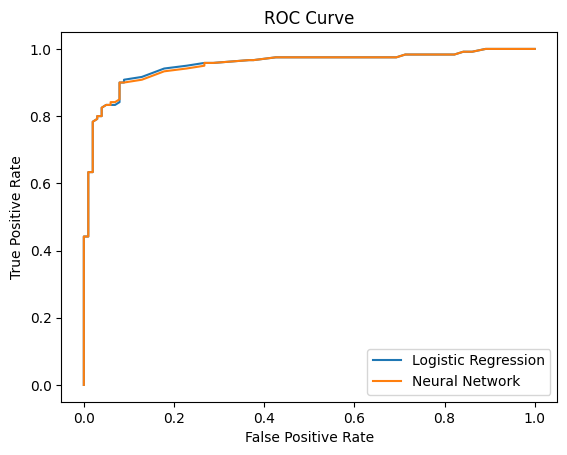

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_nn)
plt.figure()
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot(fpr_nn, tpr_nn, label="Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()